In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import json
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from datetime import datetime
import glob
import seaborn as sns
import re
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
import os

In [3]:
files = [i for i in glob.glob('*.{}'.format('csv'))]
sorted(files)

['CAvideos.csv', 'USvideos.csv']

In [4]:
#combine the data
dfs = list()
for csv in files:
    df = pd.read_csv(csv, index_col = 'video_id')
    df['country'] = csv[0:2]
    dfs.append(df)

In [5]:
#dfs[1]

In [6]:
my_df = pd.concat(dfs)

In [7]:
#type(my_df)

In [8]:
#my_df.head(1)

In [9]:
my_df = my_df.drop(columns = ['comments_disabled', 
                      'ratings_disabled', 
                      'thumbnail_link', 
                      'video_error_or_removed'])
#my_df.head(1)

In [10]:
#Reformat the date time and removed the incompleted rows
my_df['trending_date'] = pd.to_datetime(my_df['trending_date'], 
                                        errors = 'coerce', 
                                        format = '%y.%d.%m')

In [11]:
#my_df.head(10)

In [12]:
my_df['publish_time'] = pd.to_datetime(my_df['publish_time'], errors = 'coerce', format = '%Y-%m-%dT%H:%M:%S.%fZ')


In [13]:
#my_df.head(1)

In [14]:
my_df = my_df[my_df['trending_date'].notnull()]
my_df = my_df[my_df['publish_time'].notnull()]   

In [14]:
#my_df.head(1)

In [15]:
my_df = my_df.dropna(how = 'any', 
                     inplace = False, axis = 0)
my_df.insert(4, 'publish_date', 
             my_df['publish_time'].dt.date)

In [16]:
#my_df.head(1)

In [17]:
my_df['publish_time'] = my_df['publish_time'].dt.time

In [18]:
#my_df.head(1)

In [19]:
#original
my_df_full = my_df.reset_index().sort_values('trending_date').set_index('video_id')
#my_df_full.head(1)

In [20]:
#no duplicate
my_df = my_df.reset_index().sort_values('trending_date').drop_duplicates('video_id',keep='last').set_index('video_id')

In [21]:
my_df[['publish_date','publish_time']].head(1)

,publish_date,publish_time
video_id,,
5x1FAiIq_pQ,2017-11-09,15:49:21


In [86]:
my_df_full.head(1)

,trending_date,title,channel_title,category,publish_date,publish_time,tags,views,likes,dislikes,comment_count,description,country
video_id,,,,,,,,,,,,,
n1WpP7iowLc,2017-11-14,Eminem - Walk On Water (Audio) ft. Beyoncé,EminemVEVO,Music,2017-11-10,17:00:03,"Eminem|""Walk""|""On""|""Water""|""Aftermath/Shady/In...",17158579,787425,43420,125882,Eminem's new track Walk on Water ft. Beyoncé i...,CA


In [23]:
my_df['category_id'] = my_df['category_id'].astype(str)
my_df_full['category_id'] = my_df['category_id'].astype(str)

category_id = {}

with open('US_category_id.json', 'r') as f:
    data = json.load(f)
    for category in data['items']:
        category_id[category['id']] = category['snippet']['title']

In [24]:
my_df.insert(4, 'category', my_df['category_id'].map(category_id))

In [26]:
my_df_full.insert(4, 'category', my_df['category_id'].map(category_id))

In [27]:
category_list = my_df_full['category'].unique()
#category_list

In [28]:
my_df_full = my_df_full.drop(columns = ['category_id'])
my_df = my_df.drop(columns = ['category_id'])
#my_df_full.head(1)

In [197]:
#WordCloud
#What is most frequent word on Youtube

from wordcloud import WordCloud,ImageColorGenerator,STOPWORDS
from PIL import Image

Tags_list = my_df_full['tags']
Tags = [] 

for x in Tags_list:
    x = x.split('|')
    Tags.append(x)
    
word_counts = Counter()

for line in Tags:
    word_counts.update(line)
    
bkg = np.array(Image.open('YouTube-Logo.png'))

#fw = list(word_counts.elements())


def wcloud(data,bgcolor):
    plt.figure(figsize = (20,15))
    cloud = WordCloud(background_color = bgcolor, max_words = 100,  max_font_size = 50)
    cloud.generate(' '.join(data))
    plt.imshow(cloud)
    plt.axis('off')


In [198]:
del word_counts['[none]']

In [224]:
wcloud(word_counts,'white')

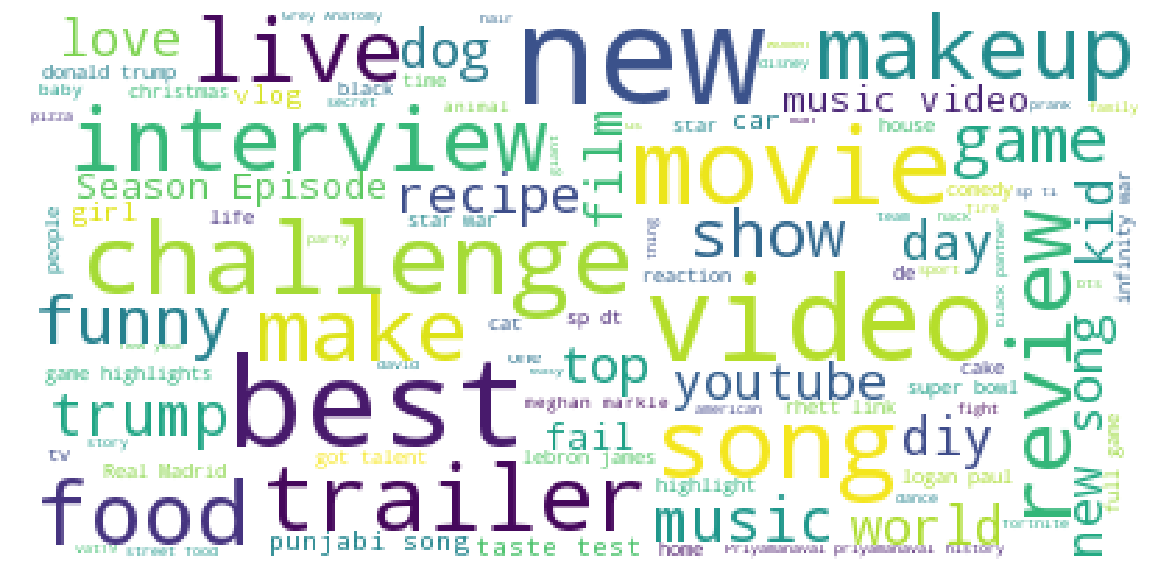

In [225]:
'''plt.title('What Tags Are Most Popular', 
          fontsize = 40,
          fontweight = 20,
          loc = 'left'
         )
'''
plt.savefig('TagCloud.png', dpi = 200)
plt.show()

In [200]:
cat = list(my_df_full['category'])

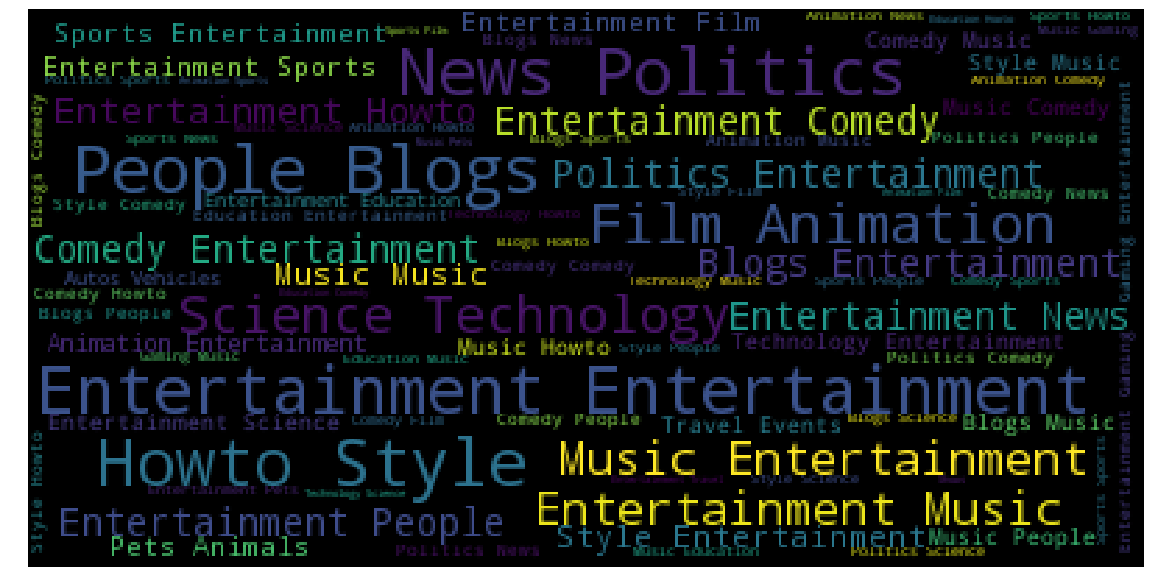

In [201]:
wcloud(cat,'black')
plt.savefig('CategoryCloud.png', dpi = 200)
plt.show()

In [202]:
cat_df_gb = my_df['category'].value_counts().reset_index()
plt.figure(figsize=(15,10))
sns.set_style("whitegrid")
ax = sns.barplot(y=cat_df_gb['index'],x=cat_df_gb['category'], data=cat_df_gb,orient='h')
plt.xlabel("Number of Videos")## From United Kingdom users : 
plt.ylabel("Categories")
plt.title("Catogories of trend videos in US&CA")
                  

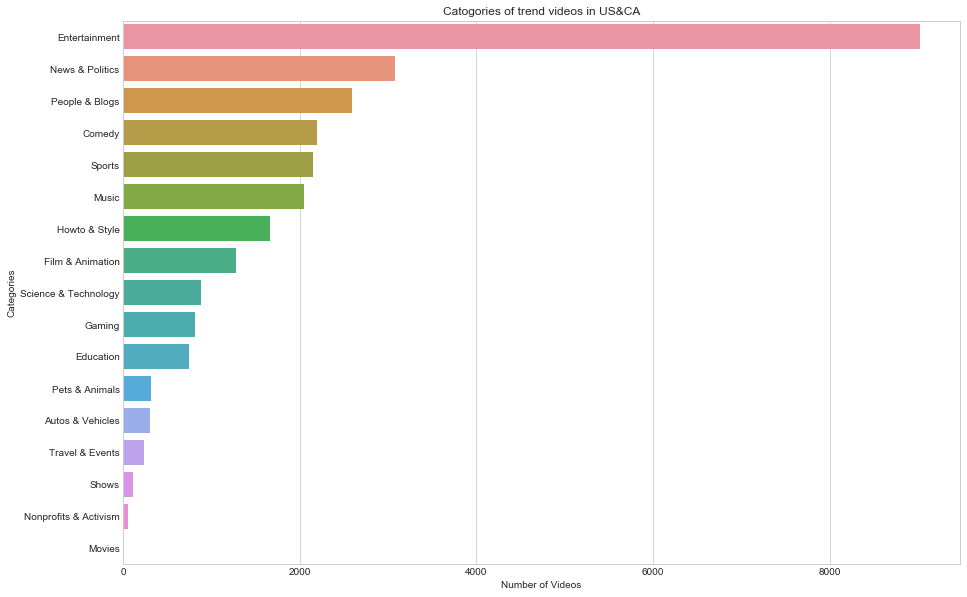

In [203]:
plt.savefig('BarTopCat.png')
plt.show()

In [204]:
#Which Category has long trend?
publish_to_trend = {}
my_df_first = my_df_full.reset_index().drop_duplicates('video_id',keep ='first').set_index('video_id')
diff_first = (my_df_first['trending_date']).astype('datetime64[ns]')-my_df_first['publish_date'].astype('datetime64[ns]')

diff_first = diff_first.reset_index()
diff_first.columns = ['video_id','publish_to_trend']

for i, row in diff_first.iterrows():
    publish_to_trend[row['video_id']] = row['publish_to_trend'].days

my_df_last = my_df
diff_last = my_df['trending_date'].astype('datetime64[ns]')-my_df['publish_date'].astype('datetime64[ns]')
diff_last = diff_last.reset_index()
diff_last.columns = ['video_id','publish_to_trend_last']
my_df = my_df.reset_index()
my_df.insert(4,'publish_to_trend_last', diff_last['publish_to_trend_last'].astype('timedelta64[D]').astype(int))
my_df.insert(4, 'publish_to_trend', my_df['video_id'].map(publish_to_trend))
my_df.insert(4, 'trend_duration', 0)
my_df['trend_duration'] = (my_df['publish_to_trend_last']-my_df['publish_to_trend'])+1
my_df.set_index('video_id')[['publish_to_trend','trend_duration']].sort_values('trend_duration',ascending=False).head()

,publish_to_trend,trend_duration
video_id,,
f4FuOi9rvKw,5,32
jYuQzAxBVZU,5,32
oJ2faqXlU1s,4,32
M4ZoCHID9GI,2,31
i5qOzqD9Rms,1,31


In [205]:
cat_trend_duration= my_df.groupby(['category','trend_duration']).count()['video_id'].unstack().clip(upper=300)
plt.figure(figsize=(15,15))#You can Arrange The Size As Per Requirement
sns.heatmap(cat_trend_duration, cmap='plasma_r')
plt.title("Category v/s Trending Duration")

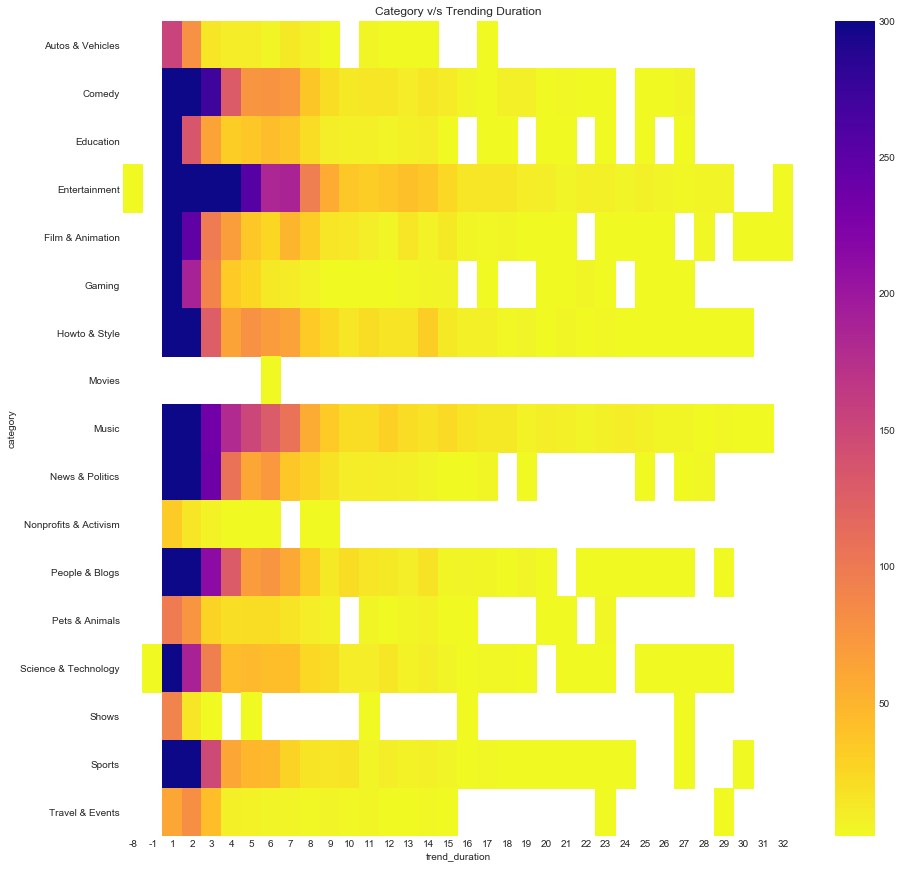

In [207]:
plt.savefig('Category vs Trending Duration.png')
plt.show()

In [258]:
my_df.head(1)

,video_id,trending_date,title,channel_title,trend_duration,publish_to_trend,publish_to_trend_last,category,publish_date,publish_time,tags,views,likes,dislikes,comment_count,description,country
0,5x1FAiIq_pQ,2017-11-14,Alicia Keys - When You Were Gone,Alicia Keys,1,5,5,Music,2017-11-09,15:49:21,[none],95944,1354,181,117,Find out more in The Vault: http://bit.ly/AK_A...,US


In [307]:
like = my_df.groupby('category')['likes'].agg('sum')/10000

In [308]:
like

category
Autos & Vehicles           375.5617
Comedy                    9451.4585
Education                 1197.7855
Entertainment            17589.4564
Film & Animation          3099.7134
Gaming                    2531.6775
Howto & Style             3714.5541
Movies                       6.7232
Music                    24077.6551
News & Politics           1857.2622
Nonprofits & Activism      373.6205
People & Blogs            5156.9713
Pets & Animals             590.7470
Science & Technology      2271.8122
Shows                       49.8994
Sports                    2791.4627
Travel & Events            223.7038
Name: likes, dtype: float64

In [309]:
like = like.sort_values(ascending = False).reset_index()

In [310]:
like

,category,likes
0,Music,24077.6551
1,Entertainment,17589.4564
2,Comedy,9451.4585
3,People & Blogs,5156.9713
4,Howto & Style,3714.5541
5,Film & Animation,3099.7134
6,Sports,2791.4627
7,Gaming,2531.6775
8,Science & Technology,2271.8122
9,News & Politics,1857.2622


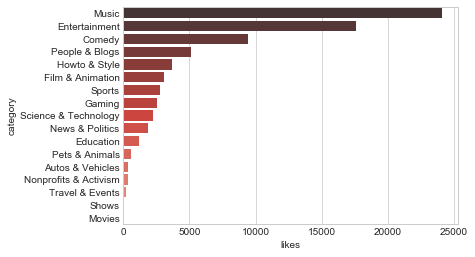

In [312]:
sns.barplot(y = "category", x = "likes", 
            data = like, palette = "Reds_d", label = "likes", ci = 0)
#sns.catplot(x="deck", kind="count", 
 #           palette="ch:.25", data=titanic);
plt.savefig('Most Liked Category.png')
plt.show()

In [330]:
my_df.head(1)

,video_id,trending_date,title,channel_title,trend_duration,publish_to_trend,publish_to_trend_last,category,publish_date,publish_time,tags,views,likes,dislikes,comment_count,description,country
0,5x1FAiIq_pQ,2017-11-14,Alicia Keys - When You Were Gone,Alicia Keys,1,5,5,Music,2017-11-09,15:49:21,[none],95944,1354,181,117,Find out more in The Vault: http://bit.ly/AK_A...,US


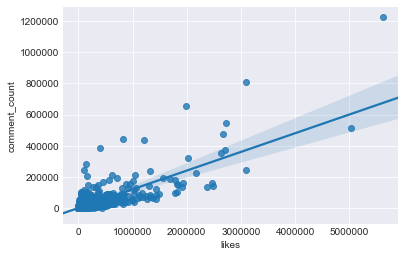

In [344]:
sns.set_style('darkgrid')
sns.regplot(x="likes", y="comment_count", data=my_df)
plt.savefig('Regression Likes & Comment.png')
plt.show()

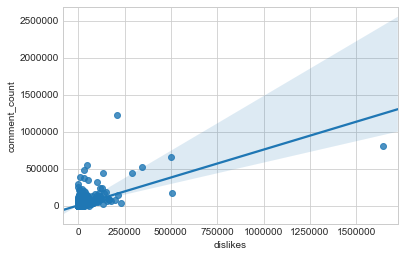

In [317]:
sns.regplot(x="dislikes", y="comment_count", data=my_df)
plt.show()